<center><h1>Tree-Based Methods on APS Failure data</h1></center>

Name: Chengyi Li
<br>
Github Username: ChengyiLi98
<br>

## 1. Tree-Based Methods

Import packages

In [2]:
import pandas as pd
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import svm
from imblearn.over_sampling import SMOTE  # scikit-learn version to be 1.2.2, not the latest one
%matplotlib inline

### (a) Download the APS Failure data

In [2]:
path_train = r'../data/aps_failure_training_set.csv'
train_set = pd.read_csv(path_train, skiprows=20)
train_set

class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001  \
0       neg   76698     na  2130706438    280      0      0      0      0   
1       neg   33058     na           0     na      0      0      0      0   
2       neg   41040     na         228    100      0      0      0      0   
3       neg      12      0          70     66      0     10      0      0   
4       neg   60874     na        1368    458      0      0      0      0   
...     ...     ...    ...         ...    ...    ...    ...    ...    ...   
59995   neg  153002     na         664    186      0      0      0      0   
59996   neg    2286     na  2130706538    224      0      0      0      0   
59997   neg     112      0  2130706432     18      0      0      0      0   
59998   neg   80292     na  2130706432    494      0      0      0      0   
59999   neg   40222     na         698    628      0      0      0      0   

      ag_002  ...   ee_002  ee_003   ee_004   ee_005   ee_006  ee_007  ee_008  \
0          0  ...  1240520  493384   721044   469792   339156  157956   73224   
1          0  ...   421400  178064   293306   245416   133654   81140   97576   
2          0  ...   277378  159812   423992   409564   320746  158022   95128   
3          0  ...      240      46       58       44       10       0       0   
4          0  ...   622012  229790   405298   347188   286954  311560  433954   
...      ...  ...      ...     ...      ...      ...      ...     ...     ...   
59995      0  ...   998500  566884  1290398  1218244  1019768  717762  898642   
59996      0  ...    10578    6760    21126    68424      136       0       0   
59997      0  ...      792     386      452      144      146    2622       0   
59998      0  ...   699352  222654   347378   225724   194440  165070  802280   
59999      0  ...   440066  183200   344546   254068   225148  158304  170384   

       ee_009 ef_000 eg_000  
0           0      0      0  
1        1500      0      0  
2         514      0      0  
3           0      4     32  
4        1218      0      0  
...       ...    ...    ...  
59995   28588      0      0  
59996       0      0      0  
59997       0      0      0  
59998  388422      0      0  
59999     158      0      0  

[60000 rows x 171 columns]

In [3]:
path_test = r'../data/aps_failure_test_set.csv'
test_set = pd.read_csv(path_test, skiprows=20)
test_set

class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001  \
0       neg      60      0          20     12      0      0      0      0   
1       neg      82      0          68     40      0      0      0      0   
2       neg   66002      2         212    112      0      0      0      0   
3       neg   59816     na        1010    936      0      0      0      0   
4       neg    1814     na         156    140      0      0      0      0   
...     ...     ...    ...         ...    ...    ...    ...    ...    ...   
15995   neg   81852     na  2130706432    892      0      0      0      0   
15996   neg      18      0          52     46      8     26      0      0   
15997   neg   79636     na        1670   1518      0      0      0      0   
15998   neg     110     na          36     32      0      0      0      0   
15999   neg       8      0           6      4      2      2      0      0   

      ag_002  ...  ee_002  ee_003  ee_004  ee_005   ee_006  ee_007  ee_008  \
0          0  ...    1098     138     412     654       78      88       0   
1          0  ...    1068     276    1620     116       86     462       0   
2          0  ...  495076  380368  440134  269556  1315022  153680     516   
3          0  ...  540820  243270  483302  485332   431376  210074  281662   
4          0  ...    7646    4144   18466   49782     3176     482      76   
...      ...  ...     ...     ...     ...     ...      ...     ...     ...   
15995      0  ...  632658  273242  510354  373918   349840  317840  960024   
15996      0  ...     266      44      46      14        2       0       0   
15997      0  ...  806832  449962  778826  581558   375498  222866  358934   
15998      0  ...     588     210     180     544     1004    1338      74   
15999      0  ...      46      10      48      14       42      46       0   

      ee_009 ef_000 eg_000  
0          0      0      0  
1          0      0      0  
2          0      0      0  
3       3232      0      0  
4          0      0      0  
...      ...    ...    ...  
15995  25566      0      0  
15996      0      0      0  
15997  19548      0      0  
15998      0      0      0  
15999      0      0      0  

[16000 rows x 171 columns]

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

I will try to use SimpleImputer just like HW5. Maybe ues imputer = KNNImputer(n_neighbors=5) later.

In [4]:
train_set.replace("na", np.nan, inplace=True)
test_set.replace("na", np.nan, inplace=True)

In [5]:
imputer = SimpleImputer(strategy='median') # since too many outliers
#imputer = KNNImputer(n_neighbors=5)  # TAKE TOO LONG TIME
col = train_set.columns

# Train set
train_without_class = train_set.iloc[:, 1:]
imputer.fit(train_without_class)
train_without_class = imputer.transform(train_without_class)
train_set = pd.concat([train_set.iloc[:, 0], pd.DataFrame(train_without_class)], axis=1)

# Test set
test_without_class = test_set.iloc[:, 1:]
imputer.fit(test_without_class)
test_without_class = imputer.transform(test_without_class)
test_set = pd.concat([test_set.iloc[:, 0], pd.DataFrame(test_without_class)], axis=1)

df_aps = pd.concat([train_set, test_set], axis=0)

df_aps = df_aps.reset_index(drop=True)
df_aps.columns = col
df_aps

class   aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0       neg  76698.0     0.0  2.130706e+09   280.0     0.0     0.0     0.0   
1       neg  33058.0     0.0  0.000000e+00   126.0     0.0     0.0     0.0   
2       neg  41040.0     0.0  2.280000e+02   100.0     0.0     0.0     0.0   
3       neg     12.0     0.0  7.000000e+01    66.0     0.0    10.0     0.0   
4       neg  60874.0     0.0  1.368000e+03   458.0     0.0     0.0     0.0   
...     ...      ...     ...           ...     ...     ...     ...     ...   
75995   neg  81852.0     0.0  2.130706e+09   892.0     0.0     0.0     0.0   
75996   neg     18.0     0.0  5.200000e+01    46.0     8.0    26.0     0.0   
75997   neg  79636.0     0.0  1.670000e+03  1518.0     0.0     0.0     0.0   
75998   neg    110.0     0.0  3.600000e+01    32.0     0.0     0.0     0.0   
75999   neg      8.0     0.0  6.000000e+00     4.0     2.0     2.0     0.0   

       ag_001  ag_002  ...     ee_002    ee_003    ee_004    ee_005    ee_006  \
0         0.0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0   
1         0.0     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   
2         0.0     0.0  ...   277378.0  159812.0  423992.0  409564.0  320746.0   
3         0.0     0.0  ...      240.0      46.0      58.0      44.0      10.0   
4         0.0     0.0  ...   622012.0  229790.0  405298.0  347188.0  286954.0   
...       ...     ...  ...        ...       ...       ...       ...       ...   
75995     0.0     0.0  ...   632658.0  273242.0  510354.0  373918.0  349840.0   
75996     0.0     0.0  ...      266.0      44.0      46.0      14.0       2.0   
75997     0.0     0.0  ...   806832.0  449962.0  778826.0  581558.0  375498.0   
75998     0.0     0.0  ...      588.0     210.0     180.0     544.0    1004.0   
75999     0.0     0.0  ...       46.0      10.0      48.0      14.0      42.0   

         ee_007    ee_008   ee_009  ef_000  eg_000  
0      157956.0   73224.0      0.0     0.0     0.0  
1       81140.0   97576.0   1500.0     0.0     0.0  
2      158022.0   95128.0    514.0     0.0     0.0  
3           0.0       0.0      0.0     4.0    32.0  
4      311560.0  433954.0   1218.0     0.0     0.0  
...         ...       ...      ...     ...     ...  
75995  317840.0  960024.0  25566.0     0.0     0.0  
75996       0.0       0.0      0.0     0.0     0.0  
75997  222866.0  358934.0  19548.0     0.0     0.0  
75998    1338.0      74.0      0.0     0.0     0.0  
75999      46.0       0.0      0.0     0.0     0.0  

[76000 rows x 171 columns]

#### (ii) Calculate the coefficient of variation

In [6]:
cv = df_aps.std() / df_aps.mean()
cv_df = pd.DataFrame({'Feature': cv.index, 'Coefficient of Variation': cv.values})
cv_df

Feature  Coefficient of Variation
0    aa_000                  4.328608
1    ab_000                  9.740521
2    ac_000                  2.309299
3    ad_000                274.791073
4    ae_000                 23.271357
..      ...                       ...
165  ee_007                  4.935373
166  ee_008                  3.373885
167  ee_009                  5.821008
168  ef_000                 50.223681
169  eg_000                 47.845392

[170 rows x 2 columns]

#### (iii) Plot a correlation matrix

<Axes: >

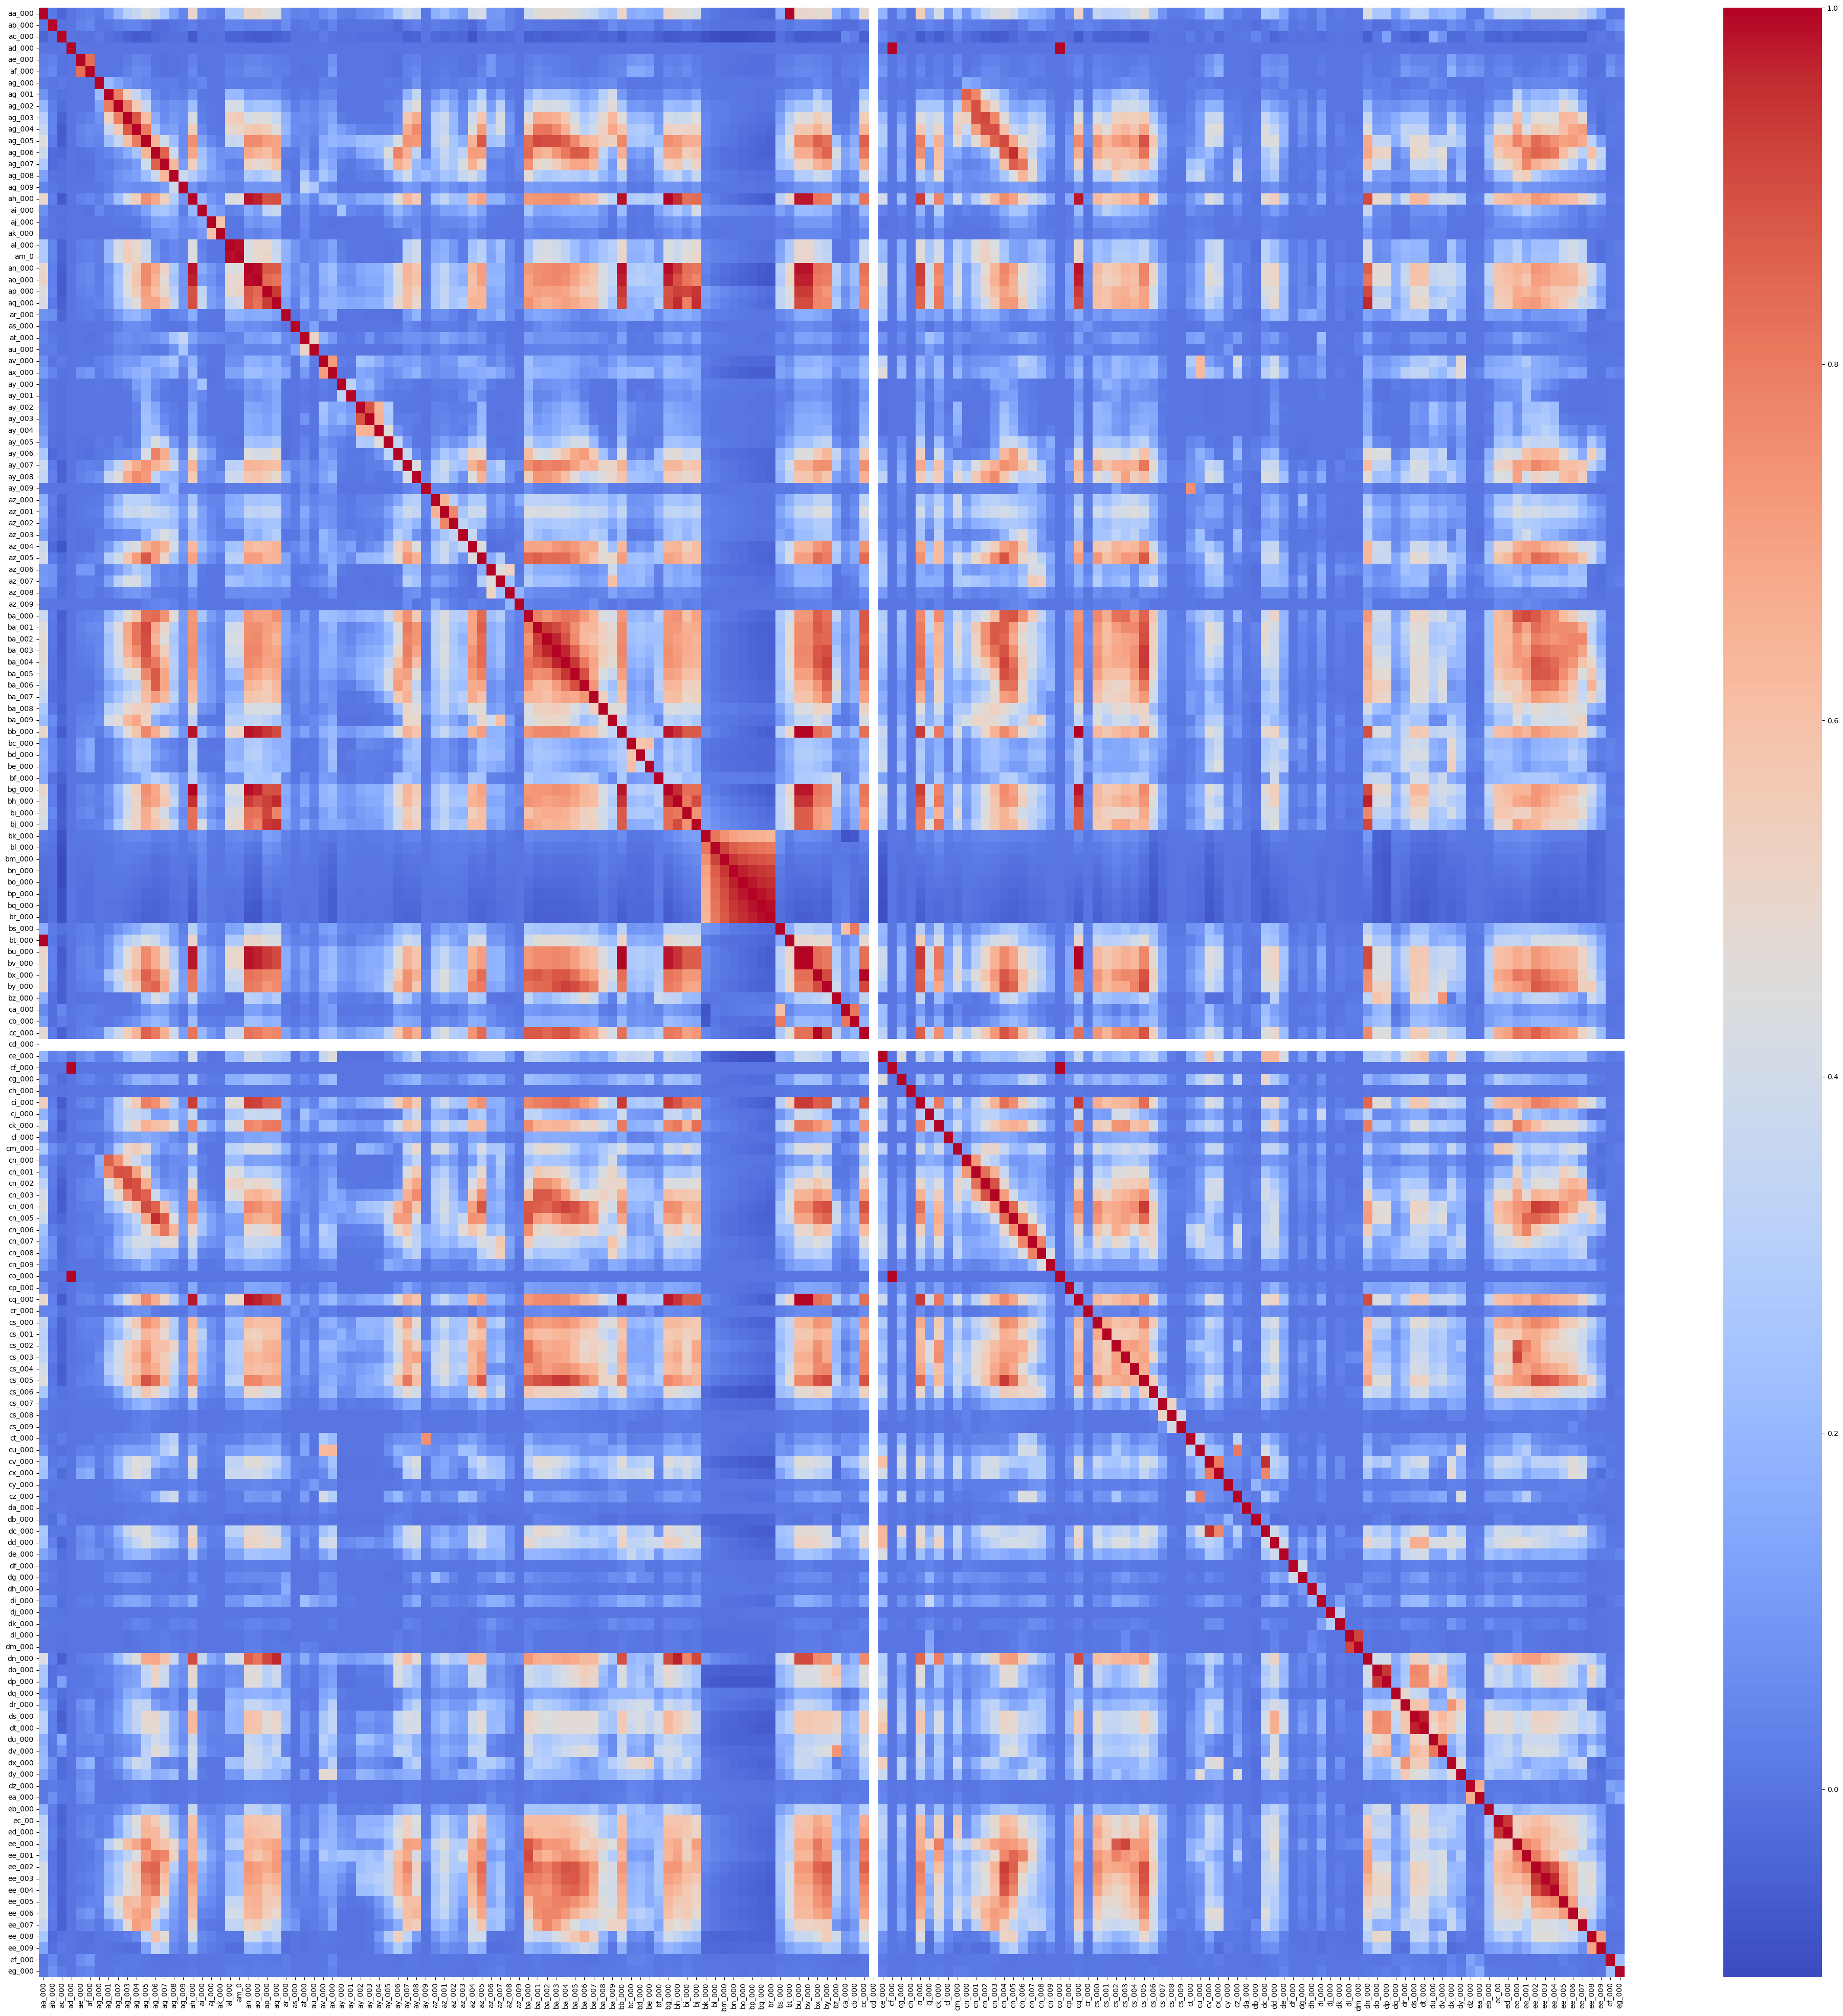

In [7]:
plt.figure(figsize=(50, 50))  # Set the size of the heatmap
sns.heatmap(df_aps.corr(), cmap='coolwarm', annot=False, fmt=".2f")

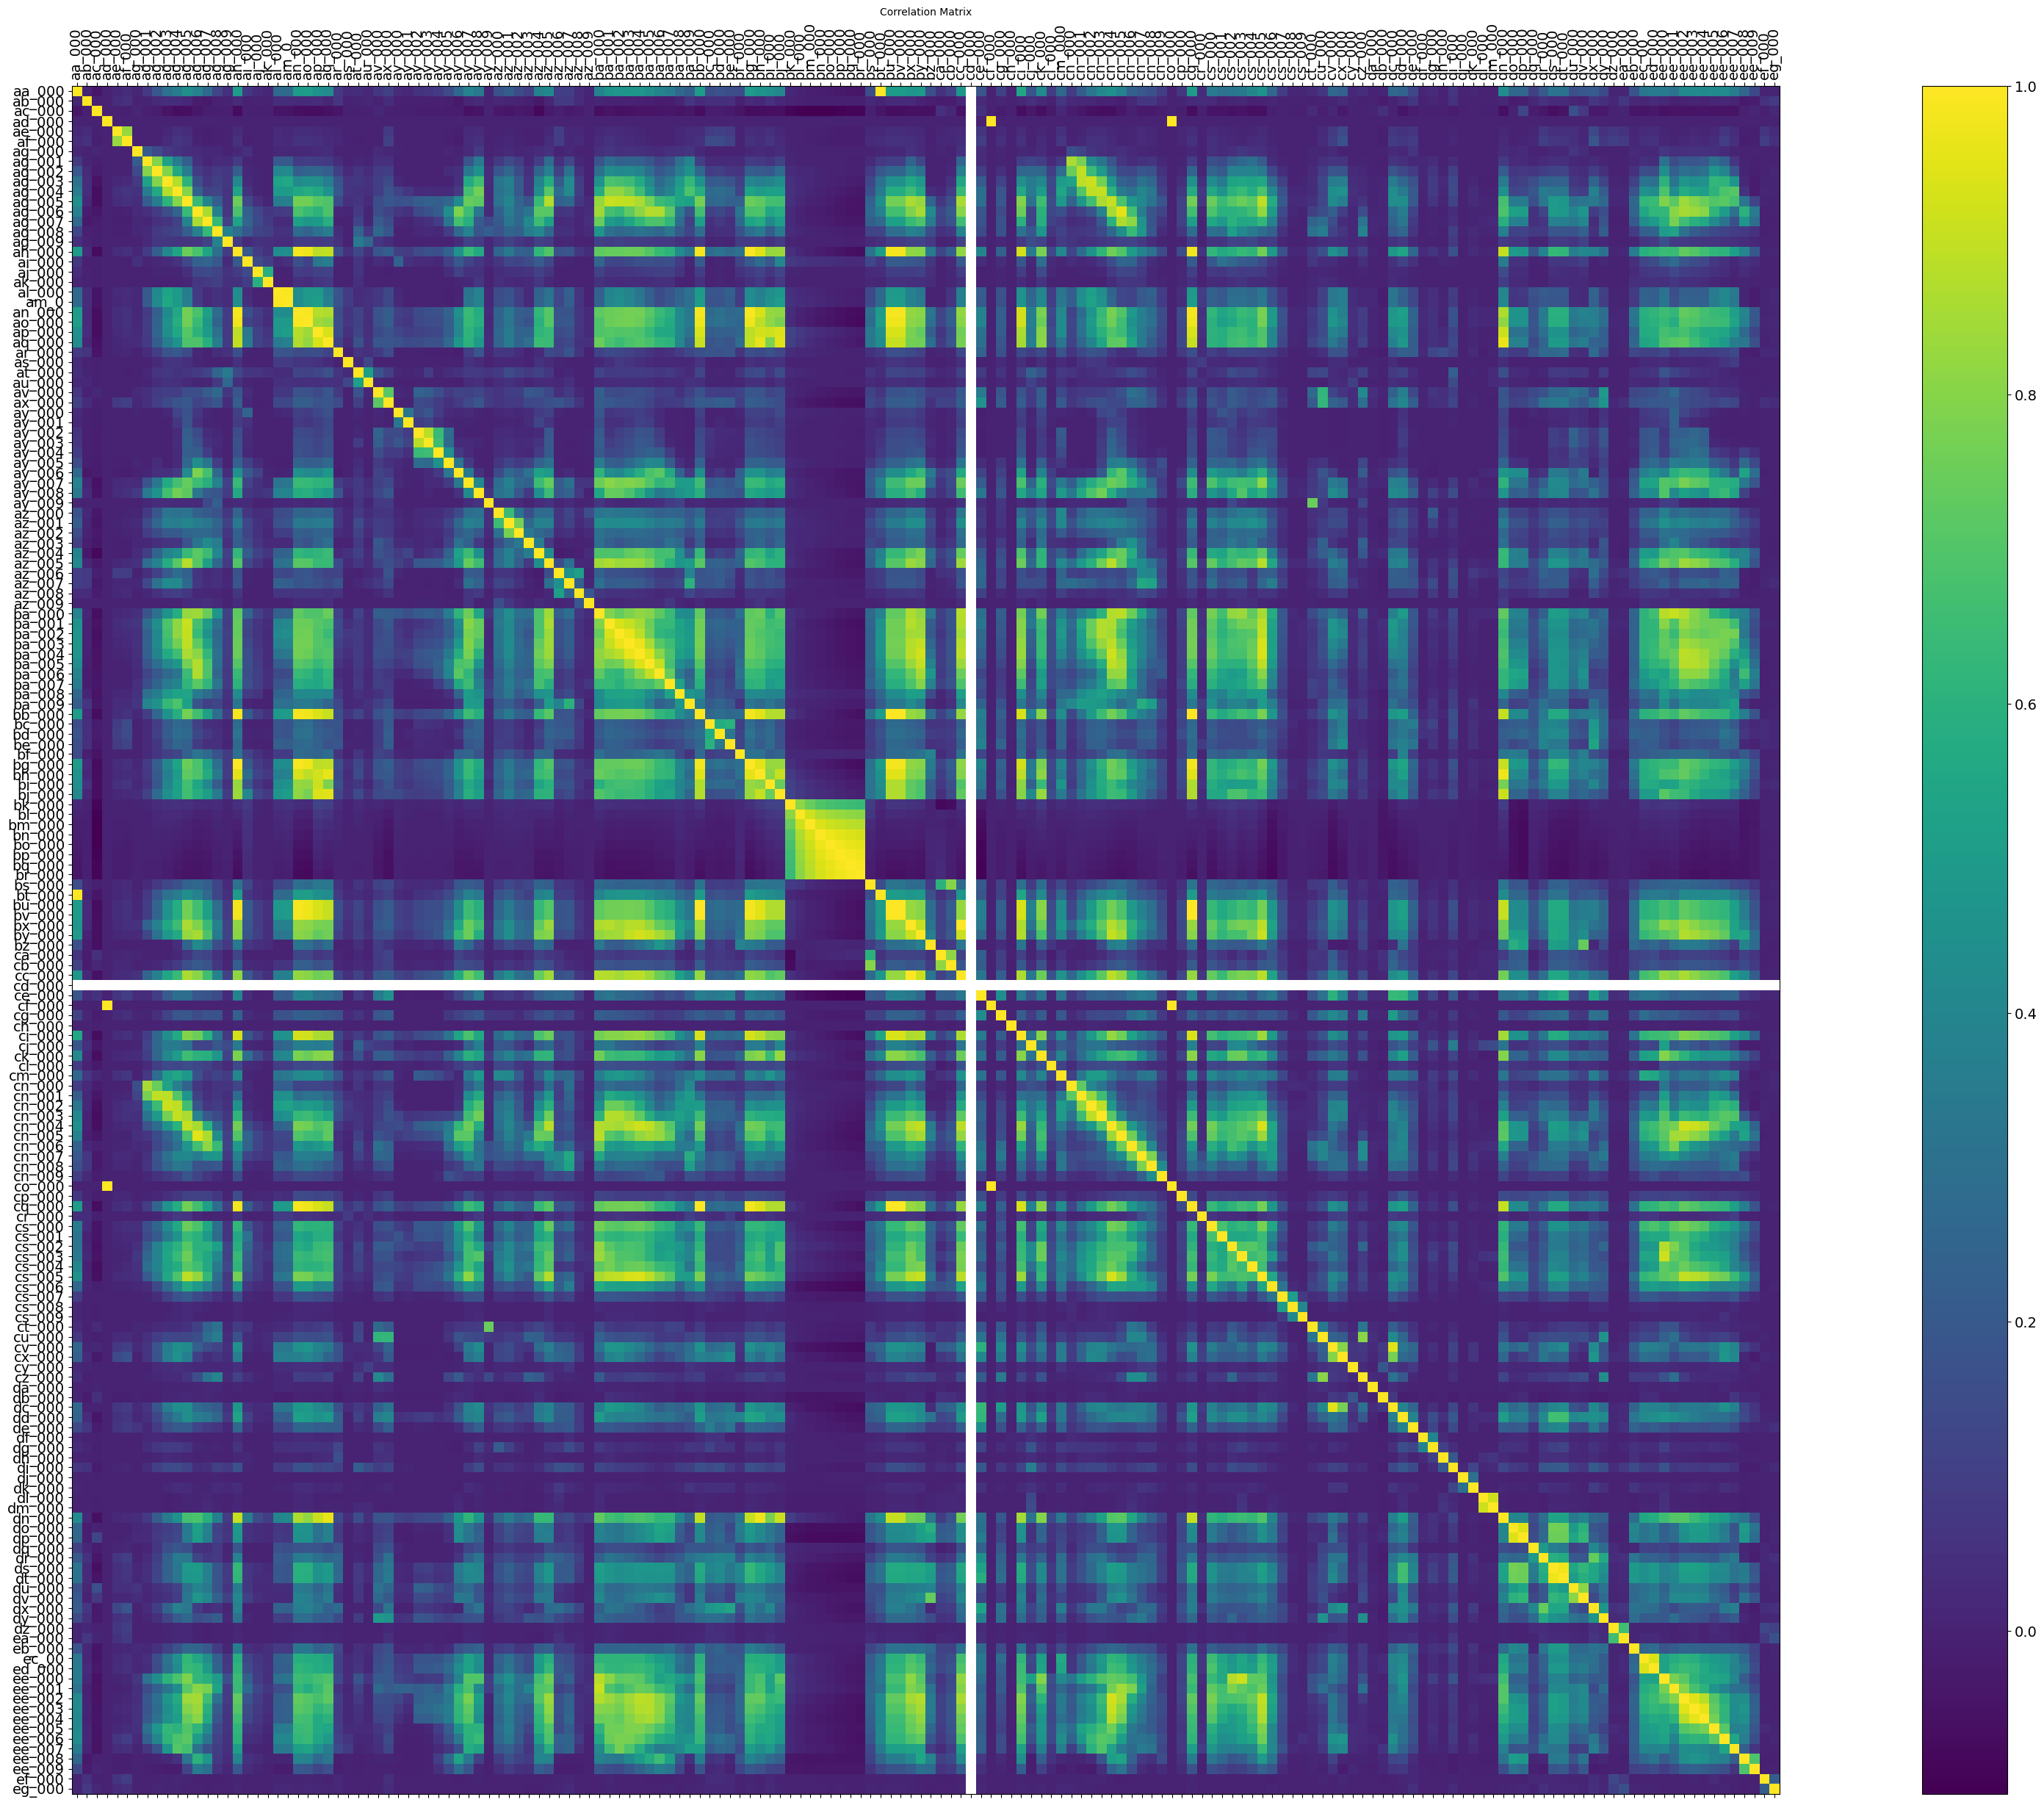

In [8]:
# another way for this part
f = plt.figure(figsize=(50, 30))
plt.matshow(df_aps.corr(), fignum=f.number)
plt.xticks(range(df_aps.select_dtypes(['number']).shape[1]), df_aps.select_dtypes(['number']).columns, fontsize=14, rotation = 90)
plt.yticks(range(df_aps.select_dtypes(['number']).shape[1]), df_aps.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=10);

#### (iv) Make scatter plots and box plots

In [9]:
num_feature = math.floor(math.sqrt(170))
highest_feature_df = cv_df.sort_values(by="Coefficient of Variation", ascending = False).head(num_feature)
highest_feature_df

Feature  Coefficient of Variation
91   cf_000                275.595820
109  co_000                275.068138
3    ad_000                274.791073
122  cs_009                194.720937
138  dj_000                130.915233
136  dh_000                120.759504
134  df_000                119.384411
27   as_000                115.082077
6    ag_000                 92.507510
29   au_000                 86.992248
19   ak_000                 84.875146
51   az_009                 78.895508
41   ay_009                 78.350868

In [10]:
selected_col = highest_feature_df['Feature']
selected_df = df_aps[selected_col]
selected_df

cf_000  co_000  ad_000  cs_009  dj_000  dh_000  df_000  as_000  ag_000  \
0         2.0   220.0   280.0     0.0     0.0     0.0     0.0     0.0     0.0   
1         2.0     8.0   126.0     0.0     0.0     0.0     0.0     0.0     0.0   
2         0.0     0.0   100.0     0.0     0.0     0.0     0.0     0.0     0.0   
3         2.0     2.0    66.0     0.0     0.0     0.0     0.0     0.0     0.0   
4         0.0   202.0   458.0     0.0     0.0     0.0     0.0     0.0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
75995     2.0    42.0   892.0     0.0     0.0     0.0     0.0     0.0     0.0   
75996     2.0     0.0    46.0     0.0     0.0     0.0     0.0     0.0     0.0   
75997     2.0   378.0  1518.0     0.0     0.0     0.0     0.0     0.0     0.0   
75998     0.0     0.0    32.0     0.0     0.0     0.0     0.0     0.0     0.0   
75999     0.0     0.0     4.0     0.0     0.0     0.0     0.0     0.0     0.0   

       au_000  ak_000  az_009  ay_009  
0         0.0     0.0     0.0     0.0  
1         0.0     0.0     0.0     0.0  
2         0.0     0.0     0.0     0.0  
3         0.0     0.0     0.0     0.0  
4         0.0     0.0     0.0     0.0  
...       ...     ...     ...     ...  
75995     0.0     0.0     0.0     0.0  
75996     0.0     0.0     0.0     0.0  
75997     0.0     0.0     0.0     0.0  
75998     0.0     0.0     0.0     0.0  
75999     0.0     0.0     0.0     0.0  

[76000 rows x 13 columns]

In [11]:
selected_df.corr()

cf_000    co_000    ad_000    cs_009    dj_000    dh_000    df_000  \
cf_000  1.000000  1.000000  1.000000 -0.000019 -0.000028 -0.000030 -0.000030   
co_000  1.000000  1.000000  1.000000 -0.000019 -0.000028 -0.000030 -0.000030   
ad_000  1.000000  1.000000  1.000000 -0.000019 -0.000028 -0.000030 -0.000030   
cs_009 -0.000019 -0.000019 -0.000019  1.000000 -0.000039 -0.000043 -0.000043   
dj_000 -0.000028 -0.000028 -0.000028 -0.000039  1.000000  0.000334 -0.000064   
dh_000 -0.000030 -0.000030 -0.000030 -0.000043  0.000334  1.000000  0.030144   
df_000 -0.000030 -0.000030 -0.000030 -0.000043 -0.000064  0.030144  1.000000   
as_000 -0.000031 -0.000032 -0.000031 -0.000045 -0.000066 -0.000072 -0.000073   
ag_000 -0.000039 -0.000039 -0.000038 -0.000055 -0.000083 -0.000084  0.004173   
au_000 -0.000042 -0.000041 -0.000041 -0.000059 -0.000087 -0.000045 -0.000096   
ak_000 -0.000043 -0.000042 -0.000041 -0.000060 -0.000090 -0.000093 -0.000097   
az_009 -0.000046 -0.000046 -0.000045 -0.000059 -0.000097 -0.000101 -0.000104   
ay_009 -0.000044 -0.000040  0.000021 -0.000065 -0.000097  0.011402  0.002662   

          as_000    ag_000    au_000    ak_000    az_009    ay_009  
cf_000 -0.000031 -0.000039 -0.000042 -0.000043 -0.000046 -0.000044  
co_000 -0.000032 -0.000039 -0.000041 -0.000042 -0.000046 -0.000040  
ad_000 -0.000031 -0.000038 -0.000041 -0.000041 -0.000045  0.000021  
cs_009 -0.000045 -0.000055 -0.000059 -0.000060 -0.000059 -0.000065  
dj_000 -0.000066 -0.000083 -0.000087 -0.000090 -0.000097 -0.000097  
dh_000 -0.000072 -0.000084 -0.000045 -0.000093 -0.000101  0.011402  
df_000 -0.000073  0.004173 -0.000096 -0.000097 -0.000104  0.002662  
as_000  1.000000 -0.000094  0.131674 -0.000102 -0.000098 -0.000075  
ag_000 -0.000094  1.000000 -0.000015 -0.000123 -0.000080  0.001876  
au_000  0.131674 -0.000015  1.000000 -0.000129 -0.000140  0.007083  
ak_000 -0.000102 -0.000123 -0.000129  1.000000  0.000077 -0.000127  
az_009 -0.000098 -0.000080 -0.000140  0.000077  1.000000  0.008444  
ay_009 -0.000075  0.001876  0.007083 -0.000127  0.008444  1.000000

In [12]:
res = pd.concat([df_aps.iloc[:,0],selected_df], axis =1)

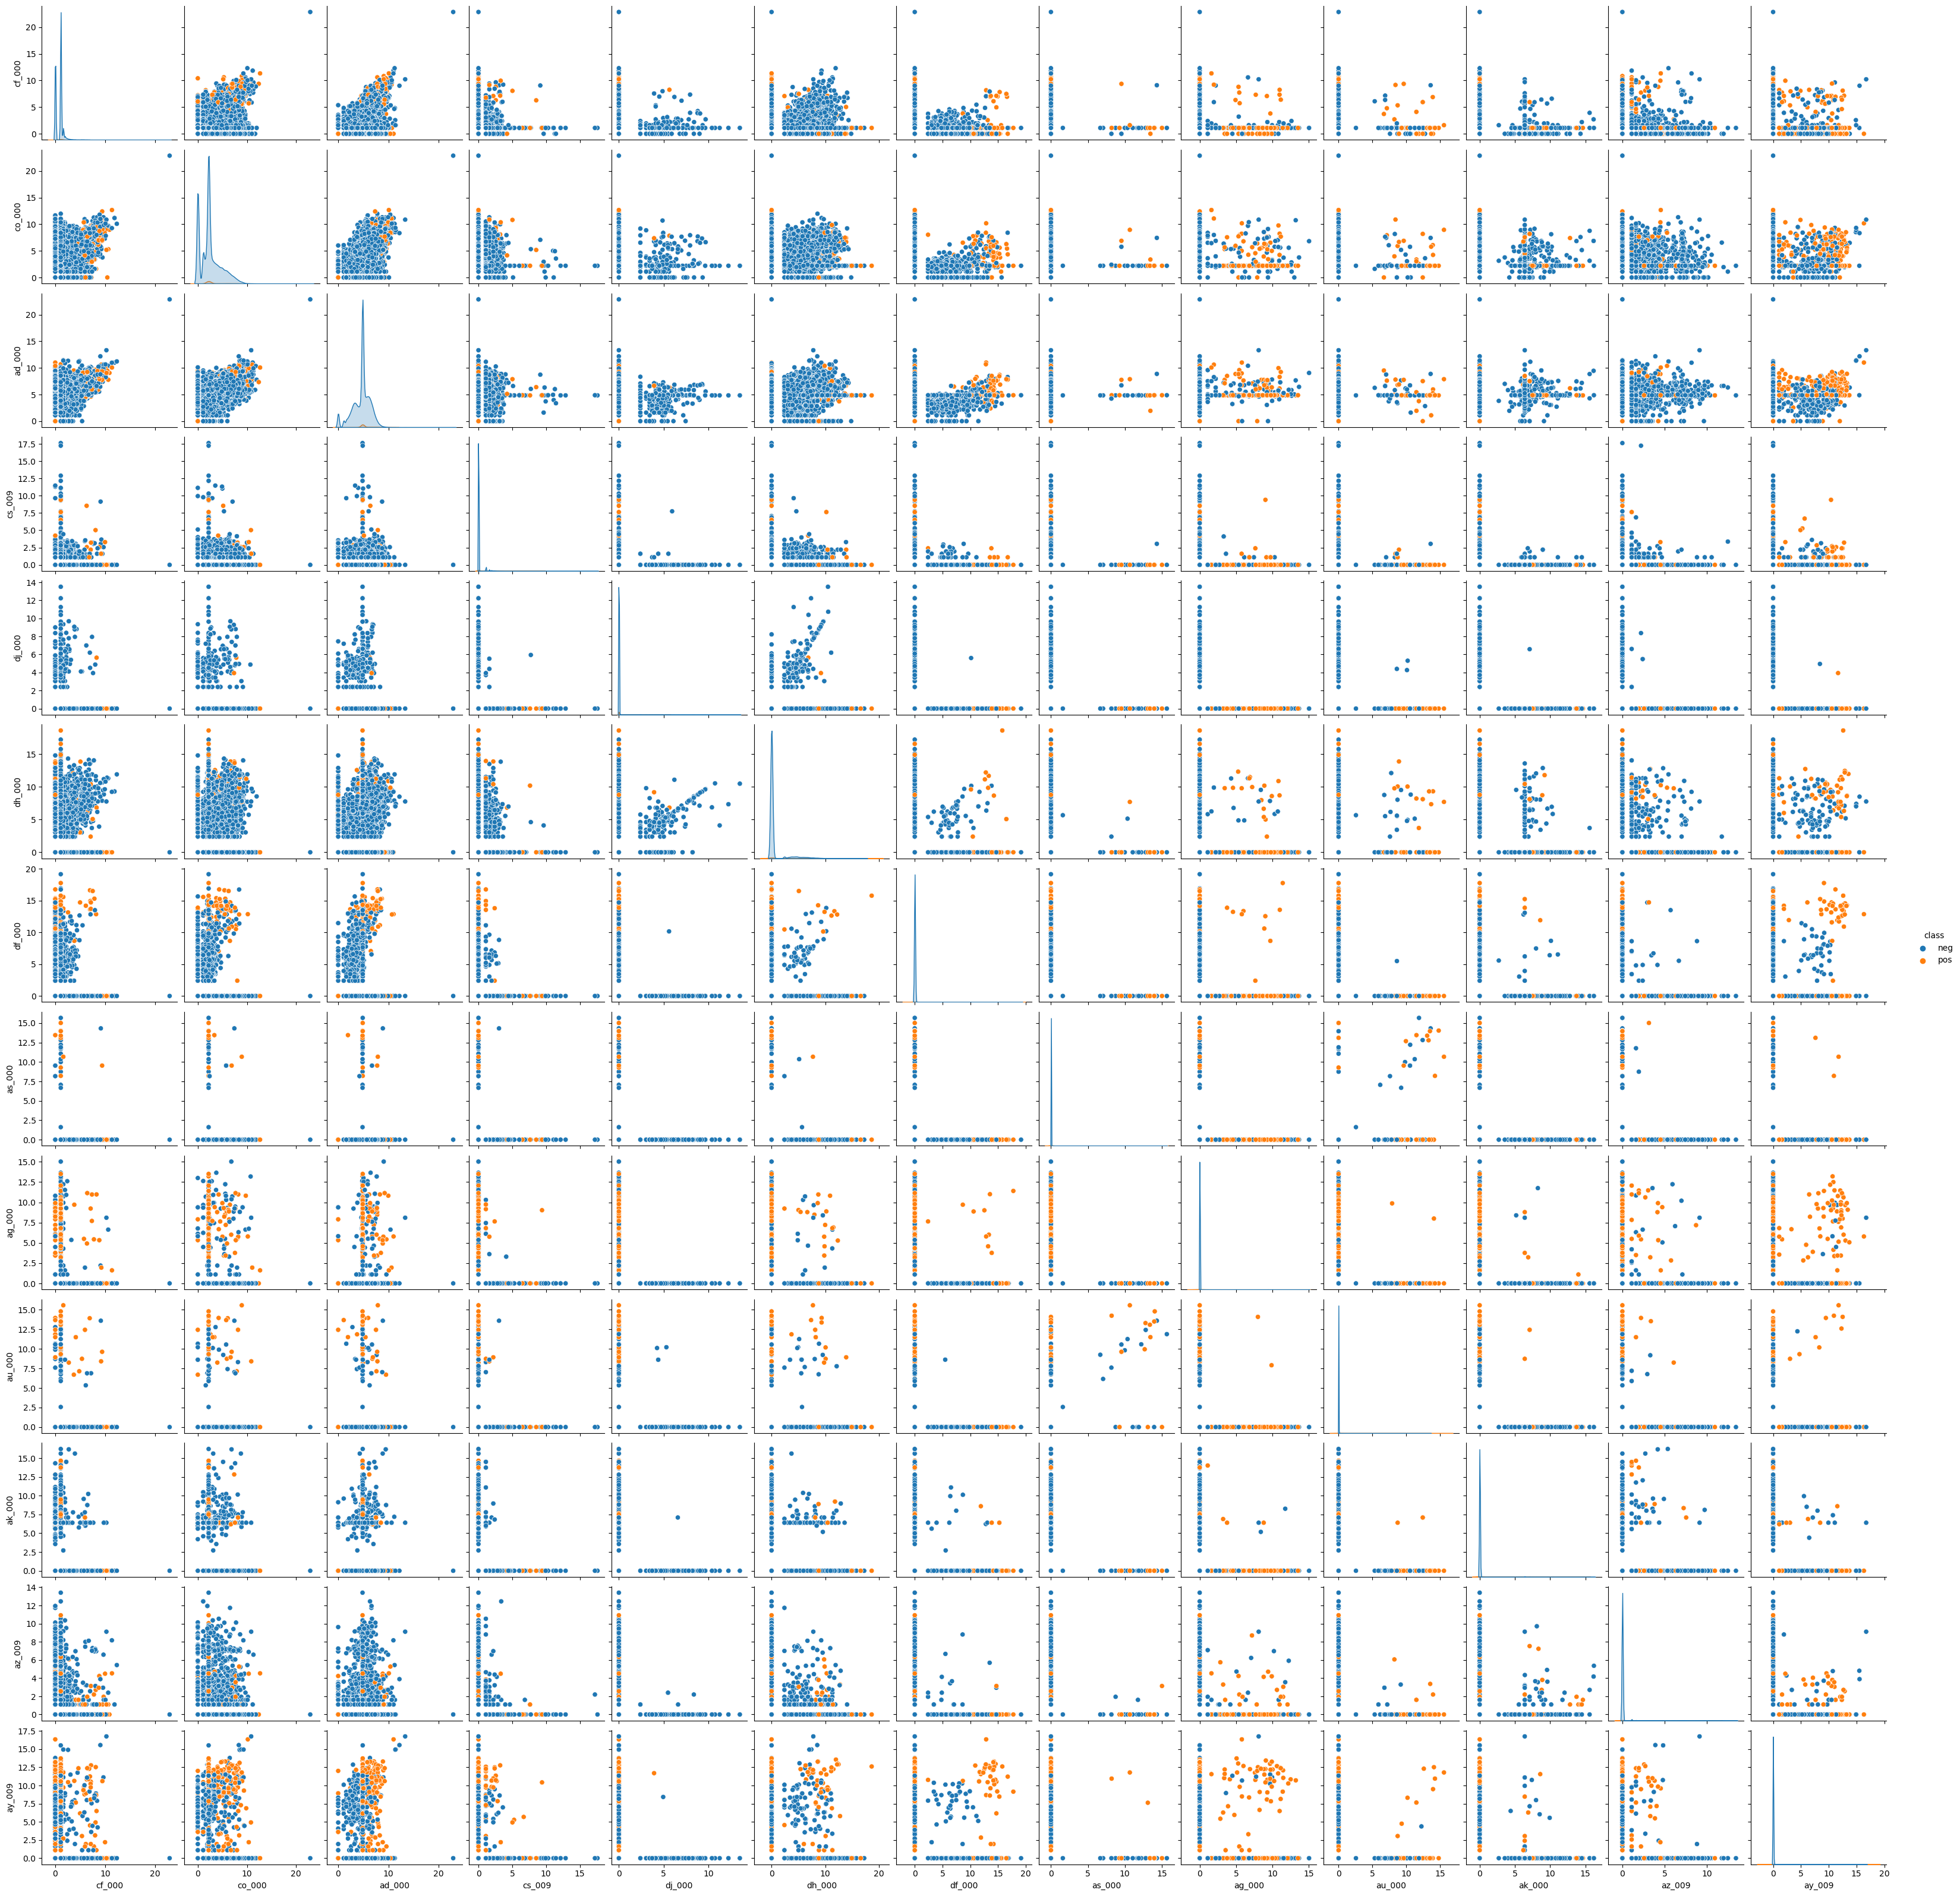

In [13]:
log_res = selected_df.copy() 
log_res = np.log1p(log_res) # log scale
res = pd.concat([df_aps.iloc[:,0],log_res], axis =1)
sns.pairplot(res, kind="scatter", hue = 'class')

I cannot draw conclusions about significance of those features just by the scatter plots, there are too many outliers.
Pairwise scatterplots can only give some information about relationships between features, but they do not directly provide information about feature significance. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'cf_000'),
  Text(1, 0, 'co_000'),
  Text(2, 0, 'ad_000'),
  Text(3, 0, 'cs_009'),
  Text(4, 0, 'dj_000'),
  Text(5, 0, 'dh_000'),
  Text(6, 0, 'df_000'),
  Text(7, 0, 'as_000'),
  Text(8, 0, 'ag_000'),
  Text(9, 0, 'au_000'),
  Text(10, 0, 'ak_000'),
  Text(11, 0, 'az_009'),
  Text(12, 0, 'ay_009')])

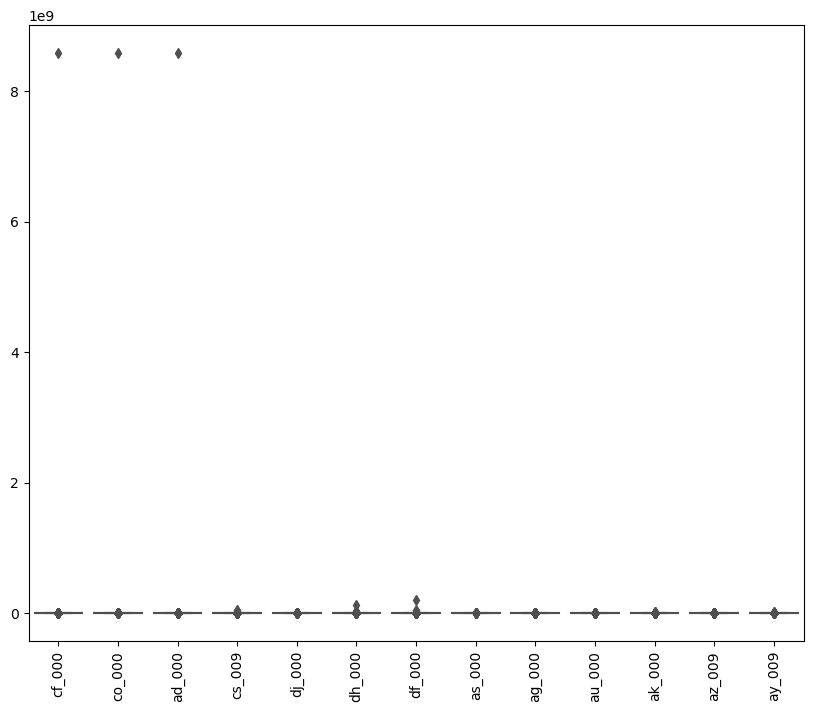

In [59]:
#boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(data=selected_df, palette = 'coolwarm')
#sns.boxplot(data=selected_df, palette = 'coolwarm', showfliers=False)
plt.xticks(rotation = 90)

#### (v) Is this data set imbalanced?

In [15]:
num_train_neg = train_set['class'].value_counts()['neg']
num_train_pos = train_set['class'].value_counts()['pos']
num_test_neg = test_set['class'].value_counts()['neg']
num_test_pos = test_set['class'].value_counts()['pos']
print(f'In training set, we have {num_train_pos} positive data, and {num_train_neg} negative data.')
print(f'In test set, we have {num_test_pos} positive data, and {num_test_neg} negative data.')
print('This is an imbalamced data set. The class distribution is heavily skewed towards the negative class')

In training set, we have 1000 positive data, and 59000 negative data.
In test set, we have 375 positive data, and 15625 negative data.
This is an imbalamced data set. The class distribution is heavily skewed towards the negative class


### (c) Train a random forest

In [16]:
def random_forest_using_different_method(model):
    X_train = train_set.iloc[:, 1:]
    y_train = train_set.iloc[:, 0]
    X_test = test_set.iloc[:, 1:]
    y_test = test_set.iloc[:, 0]
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    '''
    In scikit-learn, predict_proba returns a matrix with two columns, 
    where the first column corresponds to the predicted probabilities for the negative class (class 0),
    and the second column corresponds to the predicted probabilities for the positive class (class 1).
    So, y_train_prob and y_test_prob are arrays that contain the predicted probabilities of the positive class for the samples 
    in the training and test sets, respectively. 
    These probabilities are often used to analyze the model's confidence in its predictions and
    to calculate metrics like ROC curves and AUC values.
    '''
    #confusion matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    print('Confusion matrix for the training set is:')
    print(cm_train)

    print("Confusion matrix for the test set is:")
    print(cm_test)
    # Calculate ROC and AUC for training set
    y_train_prob = model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob, pos_label='pos')
    roc_auc_train = roc_auc_score(y_train, y_train_prob)

    # Calculate ROC and AUC for test set
    y_test_prob = model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob, pos_label='pos')
    roc_auc_test = roc_auc_score(y_test, y_test_prob)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    #  
    print("ROC AUC (Training Set):", roc_auc_train)
    print("ROC AUC (Test Set):", roc_auc_test)

    # subplot ROC（train）
    axes[0].plot(fpr_train, tpr_train, label=f'Training AUC = {roc_auc_train}')
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].set_xlim([0, 1])
    axes[0].set_ylim([0, 1.1])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve (training set)')
    axes[0].legend(loc= 'best')

    # subplot ROC（test）
    axes[1].plot(fpr_test, tpr_test, label=f'Test AUC = {roc_auc_test}')
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_xlim([0, 1])
    axes[1].set_ylim([0, 1.1])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve (test set)')
    axes[1].legend(loc= 'best')

    plt.tight_layout()
    
    # misclassification rate
    mcf_train = 1 - accuracy_score(y_train, y_train_pred)
    mcf_test = 1 - accuracy_score(y_test, y_test_pred)

    #  Out of Bag error
    OoBE = 1 - model.oob_score_

    print(f'Misclassification rate for training set is {mcf_train}')
    print(f'Misclassification rate for test set is {mcf_test}')
    print(f'Out of Bag Error rate is {OoBE}')

Confusion matrix for the training set is:
[[59000     0]
 [    0  1000]]
Confusion matrix for the test set is:
[[15608    17]
 [  102   273]]
ROC AUC (Training Set): 1.0
ROC AUC (Test Set): 0.9953442133333332
Misclassification rate for training set is 0.0
Misclassification rate for test set is 0.007437499999999986
Out of Bag Error rate is 0.005866666666666687


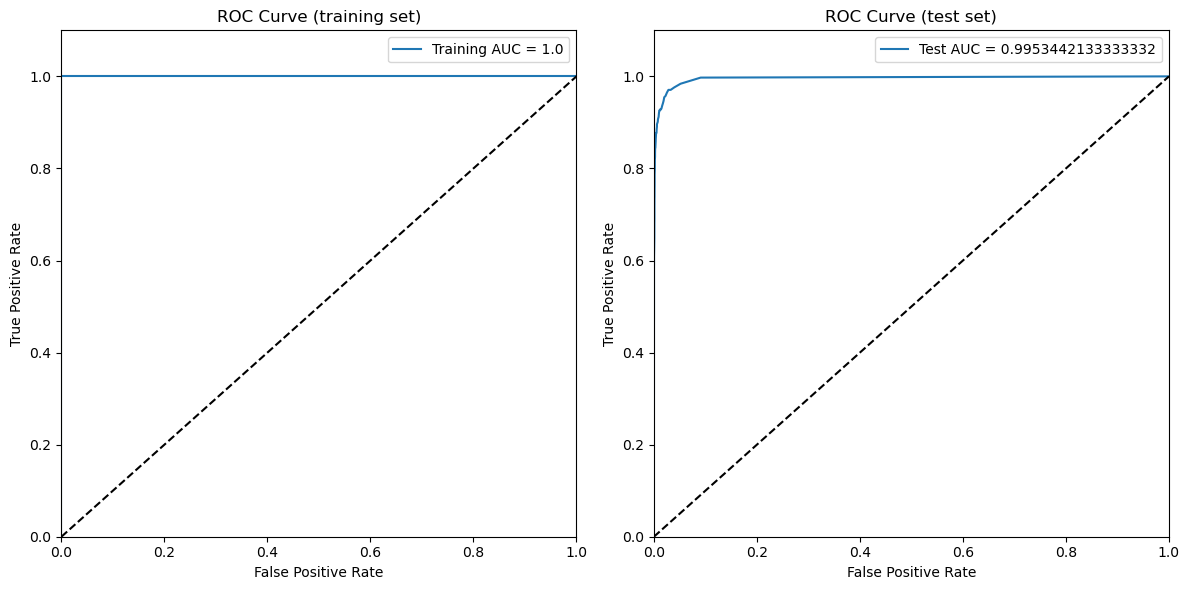

In [17]:
random_forest_using_different_method(RandomForestClassifier(oob_score=True))

### (d) Research class imbalance in random forest

We can use 'class_weight' parameter, which let us assign different weights to different classes to deal with the imbalanced issue.

Maybe we can also use RFECV (Recursive Feature Elimination with cross-validation) to determine the optimal number of features.

Confusion matrix for the training set is:
[[59000     0]
 [    0  1000]]
Confusion matrix for the test set is:
[[15611    14]
 [  159   216]]
ROC AUC (Training Set): 1.0
ROC AUC (Test Set): 0.9931630080000001
Misclassification rate for training set is 0.0
Misclassification rate for test set is 0.010812500000000003
Out of Bag Error rate is 0.007850000000000024


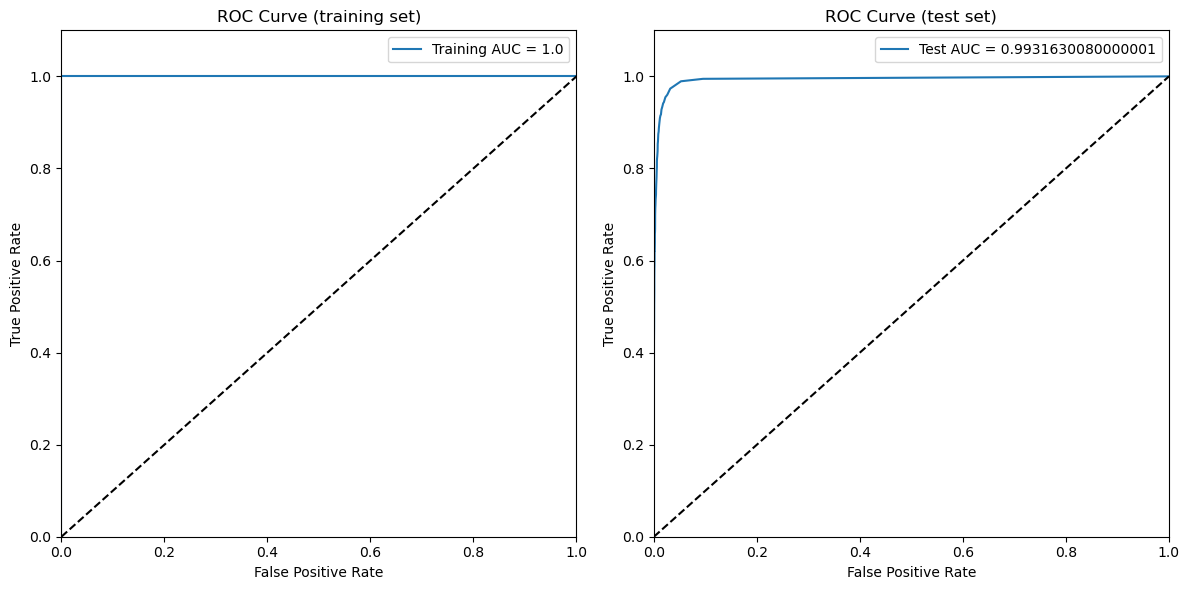

In [18]:
random_forest_using_different_method(RandomForestClassifier(class_weight="balanced", oob_score=True))

It seems that for the test set, after using balanced random forest, the confusion matrix, misclassification rate, out of bag error, ROC AUC become slightly worse.

### (e) XGBoost and Model Trees

In [38]:
value = {'neg': 0, 'pos': 1}
train_set = df_aps[:60000]
test_set = df_aps[60000:]
train_set['class'] = train_set['class'].map(value)
test_set['class'] = test_set['class'].map(value)
X_train = train_set.iloc[:, 1:]
y_train = train_set.iloc[:, 0]
X_test = test_set.iloc[:, 1:]
y_test = test_set.iloc[:, 0]

In [39]:
#Determine α (the regularization term) using cross-validation
alpha_values = np.logspace(-6, 6, 13)
best_alpha = None

param = {'reg_alpha': alpha_values}
xgb = XGBClassifier(objective='reg:logistic', random_state=66)

clf = GridSearchCV(estimator = xgb, param_grid = param, cv = StratifiedKFold(10))
clf = clf.fit(X_train,y_train)
        
best_alpha = clf.best_params_['reg_alpha']
print('Best alpha:', best_alpha)

Best alpha: 0.1


Confusion matrix for the training set is:
[[59000     0]
 [    1   999]]
Confusion matrix for the test set is:
[[15610    15]
 [   82   293]]
ROC AUC (Training Set): 0.9999997288135593
ROC AUC (Test Set): 0.9951071573333333


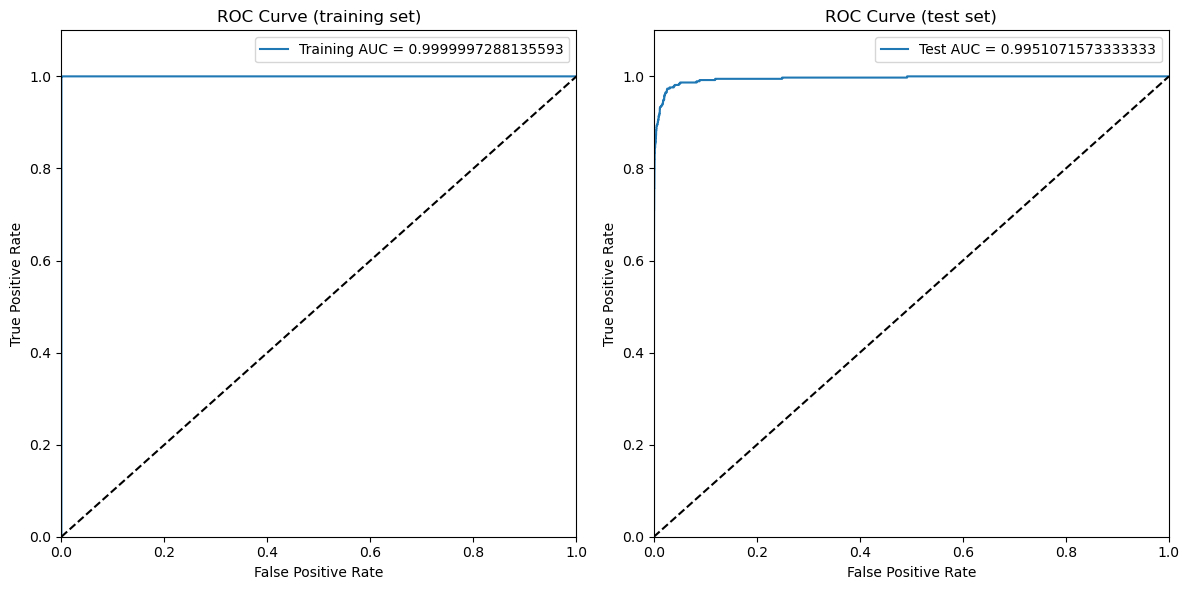

In [40]:
best_xgb_model = XGBClassifier(
    objective='reg:logistic',
    reg_alpha=best_alpha,  # Set the best alpha here
    random_state=66
)
best_xgb_model.fit(X_train, y_train)
y_train_pred = best_xgb_model.predict(X_train)
y_test_pred = best_xgb_model.predict(X_test)
#confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
print('Confusion matrix for the training set is:')
print(cm_train)

print("Confusion matrix for the test set is:")
print(cm_test)
# Calculate ROC and AUC for training set
y_train_prob = best_xgb_model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = roc_auc_score(y_train, y_train_prob)

# Calculate ROC and AUC for test set
y_test_prob = best_xgb_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = roc_auc_score(y_test, y_test_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

print("ROC AUC (Training Set):", roc_auc_train)
print("ROC AUC (Test Set):", roc_auc_test)

# subplot ROC（train）
axes[0].plot(fpr_train, tpr_train, label=f'Training AUC = {roc_auc_train}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1.1])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve (training set)')
axes[0].legend(loc= 'best')

# subplot ROC（test）
axes[1].plot(fpr_test, tpr_test, label=f'Test AUC = {roc_auc_test}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1.1])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve (test set)')
axes[1].legend(loc= 'best')

plt.tight_layout()

In [41]:
training_error = accuracy_score(y_train, y_train_pred)
print('Training Error:', 1 - training_error)
test_error = accuracy_score(y_test, y_test_pred)
print('Test Error:', 1 - test_error)

Training Error: 1.666666666666483e-05
Test Error: 0.006062499999999971


Both training error and test error are quite low, and test_error is higher than my training error.

### (f) Use SMOTE to pre-process your data

In [44]:
# applying SMOTE to each training fold separately, to get rid of leaking information to test sets in k-fold cv.
# Determine α (the regularization term) using cross-validation
alpha_values = np.logspace(-6, 6, 13)
best_alpha = None

param = {'reg_alpha': alpha_values}
xgb = XGBClassifier(objective='reg:logistic', random_state=66)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=66)
best_alpha_scores = []

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    smote = SMOTE(sampling_strategy='auto', random_state=66)
    X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    clf = GridSearchCV(estimator=xgb, param_grid=param, cv=StratifiedKFold(10), n_jobs=-1)
    clf = clf.fit(X_train_fold_resampled, y_train_fold_resampled)

    best_alpha = clf.best_params_['reg_alpha']
    best_alpha_scores.append(best_alpha)

best_alpha = np.mean(best_alpha_scores)
print('Best alpha:', best_alpha)

Best alpha (mean across folds): 0.12400119999999999


Confusion matrix for the training set is:
[[59000     0]
 [    1   999]]
Confusion matrix for the test set is:
[[15607    18]
 [   78   297]]
ROC AUC (Training Set): 0.9999989152542372
ROC AUC (Test Set): 0.9949759146666666


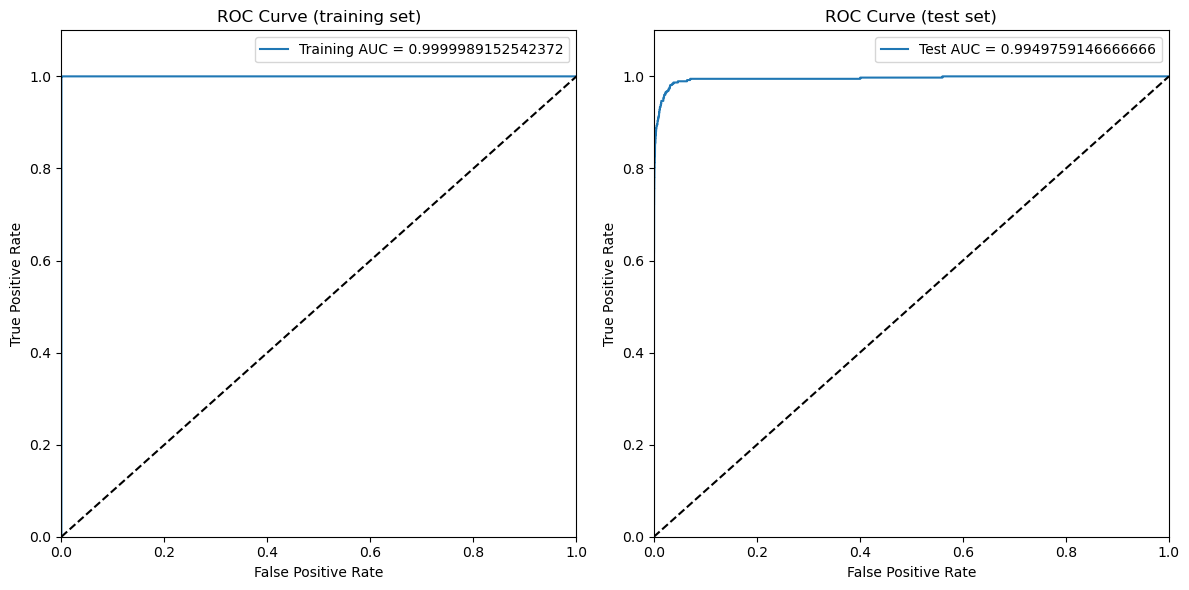

In [48]:
best_xgb_model = XGBClassifier(
    objective='reg:logistic',
    reg_alpha=best_alpha,  # Set the best alpha here
    random_state=66
)
best_xgb_model.fit(X_train, y_train)
y_train_pred = best_xgb_model.predict(X_train)
y_test_pred = best_xgb_model.predict(X_test)
#confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
print('Confusion matrix for the training set is:')
print(cm_train)

print("Confusion matrix for the test set is:")
print(cm_test)
# Calculate ROC and AUC for training set
y_train_prob = best_xgb_model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = roc_auc_score(y_train, y_train_prob)

# Calculate ROC and AUC for test set
y_test_prob = best_xgb_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = roc_auc_score(y_test, y_test_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

print("ROC AUC (Training Set):", roc_auc_train)
print("ROC AUC (Test Set):", roc_auc_test)

# subplot ROC（train）
axes[0].plot(fpr_train, tpr_train, label=f'Training AUC = {roc_auc_train}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1.1])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve (training set)')
axes[0].legend(loc= 'best')

# subplot ROC（test）
axes[1].plot(fpr_test, tpr_test, label=f'Test AUC = {roc_auc_test}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1.1])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve (test set)')
axes[1].legend(loc= 'best')

plt.tight_layout()

In [49]:
training_error = accuracy_score(y_train, y_train_pred)
print('Training Error:', 1 - training_error)
test_error = accuracy_score(y_test, y_test_pred)
print('Test Error:', 1 - test_error)

Training Error: 1.666666666666483e-05
Test Error: 0.006000000000000005


Both training error and test error are quite low, and test_error is higher than my training error.

Compare uncompensated case with SMOTE case:

It seems that the confusion matrix, ROC AUC, error for training set are almost the same.

The SMOTE case has slightly lower test errors and slightly better confusion matrix for test set.

The uncompensated case has slightly better AUC for test set.